## XAI system for Pneumonia detection using chest X-ray images

**Authors**: Alessia Fantini, Lorenzo Marini, Alessandro Quarta

# Overview of the notebook
- About the dataset
- Task to solve
- How explanation methodology can help the final user
- Pipeline of machine learning process
  - image preprocessing
  - model construction
  - validation and interpretation
  - Classification report: accuracy, precision, recall, F1-score
  - Confusion matrix
  - ROC curve
- XAI methodologies
- Conclusion
- References


# About the dataset

## Content

The dataset is organized into 3 folders (train, test, val) and contains subfolders for each image category (Pneumonia/Normal). There are 5,863 X-Ray images (JPEG) and 2 categories (Pneumonia/Normal).

Chest X-ray images (anterior-posterior) were selected from retrospective cohorts of pediatric patients of one to five years old from Guangzhou Women and Children’s Medical Center, Guangzhou. All chest X-ray imaging was performed as part of patients’ routine clinical care.

For the analysis of chest x-ray images, all chest radiographs were initially screened for quality control by removing all low quality or unreadable scans. The diagnoses for the images were then graded by two expert physicians before being cleared for training the AI system. In order to account for any grading errors, the evaluation set was also checked by a third expert.



# Task to solve
We develop an explainable AI system aiming to solve a binary classification problem. Specifically, the task is to recognize _pneumonia_ from _normal_ images.


# How explanation methodology can help the final user
The XAI system could improve the trustability of the AI decision support system. An image visualization of the most important pixels of the decision process allows a better interpretation of the model's performance.

# 1. Load data

Importing needed library

In [ ]:
import os
import math

# Packages for processing and visualization
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme()

# Package for ML and DL
import tensorflow as tf
from tensorflow import keras
from keras.utils.vis_utils import plot_model
from IPython.display import Image

from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import precision_recall_fscore_support


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Path to the image dataset
ds_path = "/content/drive/MyDrive/XAI/esame/notebook/dataset/"

In [ ]:
train_dir = ds_path + "/train"
test_dir = ds_path + "/test"

# Print the number of images for each subfolder
print("\nTrain set:\n===================")
num_pneumonia = len(os.listdir(os.path.join(train_dir, 'PNEUMONIA')))
num_normal = len(os.listdir(os.path.join(train_dir, 'NORMAL')))

print(f"PNEUMONIA = {len(os.listdir(os.path.join(train_dir, 'PNEUMONIA')))}")
print(f"NORMAL = {len(os.listdir(os.path.join(train_dir, 'NORMAL')))}")

print("\nTest set:\n===================")
print(f"PNEUMONIA = {len(os.listdir(os.path.join(test_dir, 'PNEUMONIA')))}")
print(f"NORMAL = {len(os.listdir(os.path.join(test_dir, 'NORMAL')))}")


Train set:
PNEUMONIA = 3883
NORMAL = 2311

Test set:
PNEUMONIA = 390
NORMAL = 234


For a better visualization of dataset items, we plot a bar plot

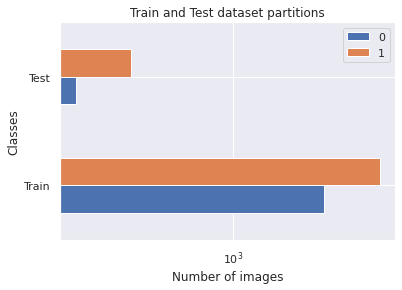

In [ ]:
data = {'0': [len(os.listdir(os.path.join(train_dir, 'NORMAL'))),
              len(os.listdir(os.path.join(test_dir, 'NORMAL'))),
              ],
        '1': [len(os.listdir(os.path.join(train_dir, 'PNEUMONIA'))),
              len(os.listdir(os.path.join(test_dir, 'PNEUMONIA'))),
              ]
        }

# Convert the dictonary into pandas DataFrame
df = pd.DataFrame(data,columns=['0','1'], index = ['Train','Test'])
df.plot.barh()
plt.title('Train and Test dataset partitions')
plt.ylabel('Classes')
plt.xlabel('Number of images')
plt.xscale('log')
plt.show()

Plotting some random images labeled as PNEUMONIA, from the training dataset

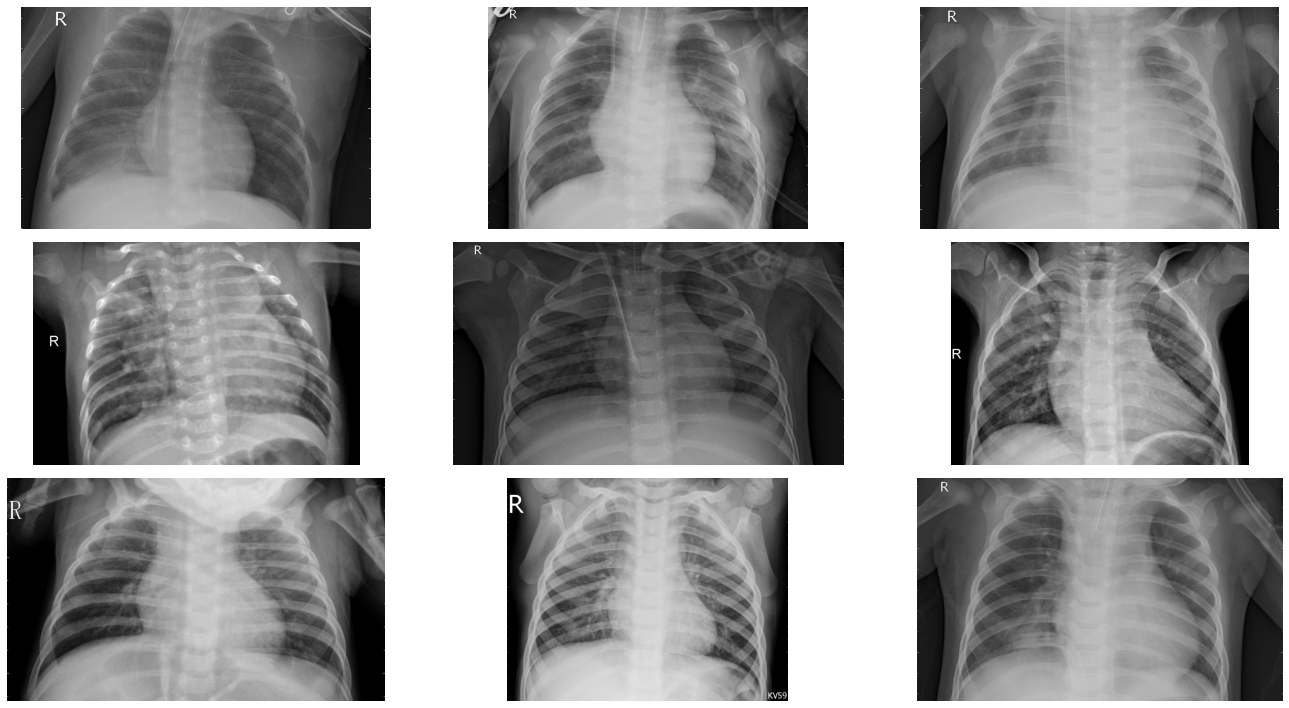

In [ ]:
pneumonia = os.listdir(ds_path + "/train/PNEUMONIA")
pneumonia_dir = ds_path + "/train/PNEUMONIA"

plt.figure(figsize=(20, 10))

for i in range(9):
    plt.subplot(3, 3, i + 1)
    img = plt.imread(os.path.join(pneumonia_dir, pneumonia[i]))
    plt.imshow(img, cmap='gray')
    plt.axis('off')

plt.tight_layout()

# 2. Image Preprocessing

## Data augmentation techinque
The dataset is unbalanced in favor of patients with pneumonia w.r.t. patients normal. In order to reduce this difference, we apply some offline data augmentation techniques that permit to obtain new data starting from original normal patients.

In [ ]:
normal = os.listdir(ds_path + "/train/NORMAL")
normal_dir = ds_path + "/train/NORMAL"

In [ ]:
import imgaug.augmenters as iaa

In [ ]:
augmentation = iaa.Sometimes(1, [
        iaa.GaussianBlur(sigma=(0.1, 2.0)),
        iaa.GammaContrast((0.5, 2.0)),
        iaa.Rotate(rotate=(-8, 8)),
        iaa.Sometimes(1, [iaa.ScaleX(scale=1.1), iaa.ScaleY(scale=1.1)]),
    ])

In [ ]:
%%script false --no-raise-error

import cv2
from google.colab.patches import cv2_imshow

for i, f in enumerate(range(len(normal))):
    img_path = os.path.join(normal_dir, normal[i])
    img = cv2.imread(img_path)
    img = augmentation.augment_image(img)
    # cv2_imshow(img)
    cv2.imwrite(f'{img_path[:-5]}_aug.jpeg', img)

Let's have a look of the new data distribution

In [ ]:
%%script false --no-raise-error
train_dir = ds_path + "/train"
test_dir = ds_path + "/test"

# Print the number of images for each subfolder
print("\nTrain set:\n===================")
num_pneumonia = len(os.listdir(os.path.join(train_dir, 'PNEUMONIA')))
num_normal = len(os.listdir(os.path.join(train_dir, 'NORMAL')))

print(f"PNEUMONIA = {len(os.listdir(os.path.join(train_dir, 'PNEUMONIA')))}")
print(f"NORMAL = {len(os.listdir(os.path.join(train_dir, 'NORMAL')))}")

print("\nTest set:\n===================")
print(f"PNEUMONIA = {len(os.listdir(os.path.join(test_dir, 'PNEUMONIA')))}")
print(f"NORMAL = {len(os.listdir(os.path.join(test_dir, 'NORMAL')))}")

data = {'0': [len(os.listdir(os.path.join(train_dir, 'NORMAL'))),
              len(os.listdir(os.path.join(test_dir, 'NORMAL'))),
              ],
        '1': [len(os.listdir(os.path.join(train_dir, 'PNEUMONIA'))),
              len(os.listdir(os.path.join(test_dir, 'PNEUMONIA'))),
              ]
        }

# Convert the dictonary into pandas DataFrame
df = pd.DataFrame(data,columns=['0','1'], index = ['Train','Test'])
df.plot.barh()
plt.title('Train and Test dataset partitions')
plt.ylabel('Classes')
plt.xlabel('Number of images')
plt.xscale('log')
plt.show()

## Dataset generation

In [ ]:
IMG_SIZE = 96 # Reshape the size of the images --> (96x96)
BATCH_SIZE = 12

In [ ]:
from keras.preprocessing.image import ImageDataGenerator

# Generate batches of tensor image data with real-time data augmentation
image_generator = ImageDataGenerator(
    rescale=1.0/255.0,
    validation_split=0.1
)

In [ ]:
train_ds = image_generator.flow_from_directory(train_dir, 
                                               batch_size=BATCH_SIZE, 
                                               shuffle=True, 
                                               class_mode='binary',
                                               target_size=(IMG_SIZE, IMG_SIZE),
                                               subset='training')

val_ds = image_generator.flow_from_directory(train_dir, 
                                               batch_size=BATCH_SIZE, 
                                               shuffle=True, 
                                               class_mode='binary',
                                               target_size=(IMG_SIZE, IMG_SIZE),
                                               subset='validation')

# val_ds = image_generator.flow_from_directory(val_dir, 
#                                             batch_size=1, 
#                                             shuffle=False, 
#                                             class_mode='binary',
#                                             target_size=(IMG_SIZE, IMG_SIZE))



test_ds = image_generator.flow_from_directory(test_dir, 
                                            batch_size=1, 
                                            shuffle=False, 
                                            class_mode='binary',
                                            target_size=(IMG_SIZE, IMG_SIZE))

Found 5575 images belonging to 2 classes.
Found 619 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


# Plot a processed image from the training dataset

Text(0.5, 1.0, 'Raw Chest X Ray Image')

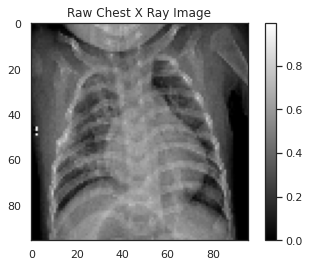

In [ ]:
sns.set_style('white')
generated_image, label = train_ds.__getitem__(10)
plt.imshow(generated_image[0], cmap='gray')
plt.colorbar()
plt.title('Raw Chest X Ray Image')

# 3. Modeling

In [ ]:
%%script false --no-raise-error
from keras.applications import ResNet50, VGG16

# base_model = ResNet50(input_shape=(IMG_SIZE,IMG_SIZE,3), include_top=False, weights='imagenet')
base_model = VGG16(input_shape=(IMG_SIZE,IMG_SIZE,3), include_top=False, weights='imagenet')

# Some info: "A guide to transfer learning with Keras using ResNet50"
# https://medium.com/@kenneth.ca95/a-guide-to-transfer-learning-with-keras-using-resnet50-a81a4a28084b#id_token=eyJhbGciOiJSUzI1NiIsImtpZCI6ImI0OWM1MDYyZDg5MGY1Y2U0NDllODkwYzg4ZThkZDk4YzRmZWUwYWIiLCJ0eXAiOiJKV1QifQ.eyJpc3MiOiJodHRwczovL2FjY291bnRzLmdvb2dsZS5jb20iLCJuYmYiOjE2NzU3NzM3OTAsImF1ZCI6IjIxNjI5NjAzNTgzNC1rMWs2cWUwNjBzMnRwMmEyamFtNGxqZGNtczAwc3R0Zy5hcHBzLmdvb2dsZXVzZXJjb250ZW50LmNvbSIsInN1YiI6IjEwODcyODA3ODAwNDU4NDA4NjIzNSIsImVtYWlsIjoibG9yZW56by5tYXJpbmkuMTk5NkBnbWFpbC5jb20iLCJlbWFpbF92ZXJpZmllZCI6dHJ1ZSwiYXpwIjoiMjE2Mjk2MDM1ODM0LWsxazZxZTA2MHMydHAyYTJqYW00bGpkY21zMDBzdHRnLmFwcHMuZ29vZ2xldXNlcmNvbnRlbnQuY29tIiwibmFtZSI6IkxvcmVuem8gTWFyaW5pIiwicGljdHVyZSI6Imh0dHBzOi8vbGgzLmdvb2dsZXVzZXJjb250ZW50LmNvbS9hL0FFZEZUcDZ3OFllcnpfYlFLQVlRT29tdTNKczhrYUJLemg5anVhZjRXTlctNVE9czk2LWMiLCJnaXZlbl9uYW1lIjoiTG9yZW56byIsImZhbWlseV9uYW1lIjoiTWFyaW5pIiwiaWF0IjoxNjc1Nzc0MDkwLCJleHAiOjE2NzU3Nzc2OTAsImp0aSI6IjQyM2YzZTNlMDJiNWFhYzM5NTRiODgwZWMyNDRjYzg3OTg2YjI3OWYifQ.l-ZqdIEJ4dIZ4K5jxcv19RGgPosIZ_cCYKIKehMLuRgbTklOnIJceqKWovfJHClkA8FrkpWi1bpG-2j-Lb__e9ulDosmapN3Nu8zvGIlP1T7YnvTFbL2cPkcOEBtczdiEIRiBt_PsnQq8QN2iDCYw31Zv-YcfvSJAiXytBYzopckN85JqfGkx3gxqT-tMtgDyEll1GkxOyho1xTcqmXs6UfgS2lToKwy1iDpk0METgV34_ZkFjerBaKHUxitZWpXrFkqBaMB60ak4f4LC_lXnFx0jUARIeTAq-WAb_11houX8l8P8xzRsXPfHSLRd8QnwwHg5M5WmY1IwXW0lxTJ8g

Procede with the two-step training, in which first we train only the _head_ of the model (we frozen the backbone) and the fine-tune all the network.

In [ ]:
%%script false --no-raise-error
base_model.trainable = False

The starting point is very advantageous since we have weights that already serve for image classification, but since we are using it on a completely new dataset, there is a need for adjustmenta.

Objective: we want to achieve an **high accuracy** on training data but we also wish that it doesn’t have **overfitting**.

In [ ]:
from keras.models import Sequential
from keras import layers

In [ ]:
%%script false --no-raise-error
# Define the network architecture

last = base_model.get_layer('block3_pool').output
x = layers.GlobalAveragePooling2D()(last)
x = layers.Dense(256, activation = 'relu')(x)
x = layers.Dropout(0.2)(x)
x = layers.Dense(128, activation = 'relu')(x)
x = layers.Dropout(0.2)(x)
x = layers.Dense(32, activation = 'relu')(x)
pred = layers.Dense(1, activation = 'sigmoid')(x)
model = keras.Model(base_model.input, pred)

model.summary()

# Compile the model
lr = 0.01
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=lr), loss='binary_crossentropy', metrics='accuracy')

In [ ]:
%%script false --no-raise-error
#Sketch of network's architecture
plot_model(model,
           to_file='model_plot.png',
           show_shapes=True,
           show_layer_names=True
           )

Image(retina=True, filename='model_plot.png')

## Training phase (skip if already done)

In [ ]:
# Compute the initial bias of the training dataset
initial_bias = np.log([num_pneumonia/num_normal])
initial_bias

array([0.51892772])

In [ ]:
TRAIN_IMG_COUNT = train_ds.__len__()
VAL_IMG_COUNT = val_ds.__len__()

weight_for_0 = (1 / num_normal)*(TRAIN_IMG_COUNT)/2.0 
weight_for_1 = (1 / num_pneumonia)*(TRAIN_IMG_COUNT)/2.0

class_weight = {0: weight_for_0, 1: weight_for_1}

print(f'Weight for class 0: {weight_for_0:.2f}')
print(f'Weight for class 1: {weight_for_1:.2f}')

Weight for class 0: 0.10
Weight for class 1: 0.06


We set the initial epochs for training just the head of our model.

In [ ]:
initial_epochs = 15

Callbacks definition

In [ ]:
chekpoint_model_path = "/content/drive/MyDrive/XAI/esame/notebook/chekpoint_model/"

In [ ]:
%%script false --no-raise-error
checkpoint_cb = tf.keras.callbacks.ModelCheckpoint(chekpoint_model_path + "xray_model.h5",
                                                   save_best_only=True)

early_stopping_cb = tf.keras.callbacks.EarlyStopping(patience=10,
                                                     restore_best_weights=True)

decay = lr / initial_epochs
def lr_time_based_decay(epoch, lr):
    if epoch<10:
      return lr
    else:
      return lr * 1 / (1 + decay * epoch)

lr_scheduler = tf.keras.callbacks.LearningRateScheduler(lr_time_based_decay)

In [ ]:
%%script false --no-raise-error
history = model.fit(train_ds,
                    batch_size=BATCH_SIZE,
                    epochs=initial_epochs,
                    validation_data=val_ds,
                    class_weight=class_weight,
                    callbacks=[checkpoint_cb, early_stopping_cb, lr_scheduler]
                    )

In [ ]:
%%script false --no-raise-error
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

Now, we train the whole model for better optimization of the weights.

In [ ]:
%%script false --no-raise-error
base_model.trainable = True

In [ ]:
%%script false --no-raise-error
# Let's take a look to see how many layers are in the base model
print("Number of layers in the base model: ", len(base_model.layers))

In [ ]:
%%script false --no-raise-error
# Fine-tune from this layer onwards
fine_tune_at = 4

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
    layer.trainable = False

In [ ]:
%%script false --no-raise-error
decay = lr / initial_epochs
def lr_time_based_decay(epoch, lr=0.01):
    if epoch<25:
      return lr
    else:
      return lr * 1 / (1 + decay * epoch)

lr_scheduler = tf.keras.callbacks.LearningRateScheduler(lr_time_based_decay)

In [ ]:
%%script false --no-raise-error
model.compile(loss='binary_crossentropy',
              optimizer = 'adam',
              metrics=['accuracy'])

In [ ]:
%%script false --no-raise-error
model.summary()

In [ ]:
%%script false --no-raise-error
len(model.trainable_variables)

In [ ]:
%%script false --no-raise-error
fine_tune_epochs = 55
total_epochs =  initial_epochs + fine_tune_epochs

history_fine = model.fit(train_ds,
                         epochs=total_epochs,
                         batch_size=BATCH_SIZE,
                         initial_epoch=history.epoch[-1],
                         validation_data=val_ds,
                         class_weight=class_weight,
                         callbacks=[checkpoint_cb, early_stopping_cb, lr_scheduler]
                         )

Have a look at the metrics after fine tuning

In [ ]:
%%script false --no-raise-error
acc += history_fine.history['accuracy']
val_acc += history_fine.history['val_accuracy']

loss += history_fine.history['loss']
val_loss += history_fine.history['val_loss']

In [ ]:
%%script false --no-raise-error
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.ylim([0.8, 1])
plt.plot([initial_epochs-1,initial_epochs-1],
          plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.ylim([0, 1.0])
plt.plot([initial_epochs-1,initial_epochs-1],
         plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')

plt.xlabel('epoch')
plt.show()

Save model

In [ ]:
model_path = "/content/drive/MyDrive/XAI/esame/notebook/model_functional"

In [ ]:
%%script false --no-raise-error
model.save(model_path)

## Prediction and performace on test data


Load the trained model

In [ ]:
from keras.models import load_model
# Loads the weights
# model.load_weights(chekpoint_model_path + "/xray_model.h5")

model = keras.models.load_model(model_path)

Evaluate the accuracy of the model on the test dataset

In [ ]:
evaluation = model.evaluate(test_ds)
print(f"Test Accuracy: {evaluation[1] * 100:.2f}%")

624/624 [==============================] - 17s 18ms/step - loss: 0.9386 - accuracy: 0.8093
Test Accuracy: 80.93%


Compute the predicted labels

In [ ]:
from sklearn.metrics import accuracy_score

y_pred = model.predict(test_ds)
y_pred = y_pred.round()

624/624 [==============================] - 10s 15ms/step


In [ ]:
from tqdm import tqdm

# Exctract the images and the labels of the test dataset
X_test = []
y_test = []

for i in tqdm(range(len(test_ds))):
  X, label = test_ds.__getitem__(i)
  y_test.append(label)
  X = np.squeeze(X, axis=0)
  X_test.append(X)
  
# From list to numpy array
X_test = np.array(X_test)
y_test = np.array(y_test)

100%|██████████| 624/624 [00:07<00:00, 85.82it/s] 


Print the classification report.

Remember:

$Precision = \frac{true positive}{true positive + false positive}$

$Recall = \frac{true positive}{true positive + false negative}$

$F1_{score} = \frac{2*precision*recall}{precision + recall}$

$Accuracy = \frac{true positive + true negative}{true positive + true negative + false positive + false negative}$

In [ ]:
from sklearn.metrics import classification_report

print(classification_report(y_test, y_pred.round(), target_names=['NORMAL','PNEUMONIA']))

              precision    recall  f1-score   support

      NORMAL       0.98      0.50      0.66       234
   PNEUMONIA       0.77      0.99      0.87       390

    accuracy                           0.81       624
   macro avg       0.87      0.75      0.77       624
weighted avg       0.85      0.81      0.79       624



Print the singole metrics

In [ ]:
precision, recall, fscore, support = precision_recall_fscore_support(y_test, y_pred.round(), average='macro')

print(f'Precision : {precision:.2f}')
print(f'Recall    : {recall:.2f}')
print(f'F-score   : {fscore:.2f}')
print(f'Accuracy  : {accuracy_score(y_test, y_pred.round()):.2f}')

Precision : 0.87
Recall    : 0.75
F-score   : 0.77
Accuracy  : 0.81


### Confusion matrix

Confusion matrix, without normalization
[[118 116]
 [  3 387]]


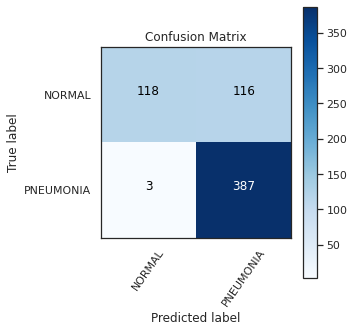

In [ ]:
from sklearn.metrics import confusion_matrix
import itertools

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    Plot the confusion matrix.

    Parameters
    ----------
    cm : sklearn object
        Confusion matrix metrics computed with sklearn
    classes : str
        Binary classification labels.
    title : str
        Title of plot.
    cmap : matplotlib object
        Colors of the matrix.

    Returns
    -------
    Fig
        Show the confusion matrix plot.
    """

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.figure(1, figsize=(5,5))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=55)
    plt.yticks(tick_marks, classes)
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.

    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()


sns.set(style='white')
cm = confusion_matrix(y_test, y_pred.round())
cm_plot_label = ['NORMAL', 'PNEUMONIA']
plot_confusion_matrix(cm, cm_plot_label, title ='Confusion Matrix')

### ROC curve

roc_auc = 0.933


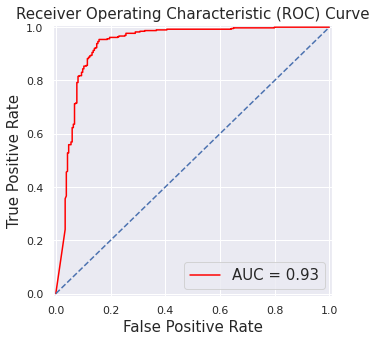

In [ ]:
from sklearn.metrics import roc_auc_score, auc
from sklearn.metrics import roc_curve

false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_pred)
roc_auc = auc(false_positive_rate, true_positive_rate)
print(f'roc_auc = {roc_auc:.3f}')

# Make plot
sns.set_theme()
plt.figure(figsize=(5,5))
plt.title('Receiver Operating Characteristic (ROC) Curve', fontsize=15)
plt.plot(false_positive_rate,true_positive_rate, color='red',label = f'AUC = {roc_auc:.2f}')
plt.plot([0, 1], [0, 1],linestyle='--')
plt.axis('tight')
plt.xlim([-0.01, 1.01])
plt.ylim([-0.01, 1.01])
plt.xlabel('False Positive Rate', fontsize=15)
plt.ylabel('True Positive Rate', fontsize=15)
plt.legend(loc="lower right", prop={'size': 15})


# Explainability


After the first training, we could skip the training phase and load directly the model

## Model Explanation with LIME

How the LIME framework can be used to identify superpixels or regions from the image used by the model to predict the specific outcome.

In [ ]:
!pip install lime

from IPython.display import clear_output
clear_output()

In [ ]:
import lime
from lime import lime_image
from skimage.segmentation import mark_boundaries

In [ ]:
def explain_image(image, index):
    """
    This function utilize Lime explainer to generate saliency maps.

    Parameters
    ----------
    image : numpy array 
        Matrix of pixels
    index : Int
        Index of the image

    Returns
    -------
    Display image with the saliency maps generated by LIME.
    """

    # Create the Explainer
    explainer = lime_image.LimeImageExplainer(verbose=True)
    explanation = explainer.explain_instance(image.astype('double'),
                                             model.predict,
                                             top_labels=5,
                                             hide_color=0,
                                             num_samples=1000)
    temp, mask = explanation.get_image_and_mask(explanation.top_labels[0],
                                                positive_only=False,
                                                num_features=10,
                                                hide_rest=False)

    # Visualization
    plt.tight_layout()
    plt.imshow(mark_boundaries(temp / 2 + 0.5, mask))
    plt.title('Predicted - ' + str('Normal' if y_pred[index] == 0 else 'Pneumonia') + '\n Ground Truth - ' + str('Normal' if y_test[index] == 0 else 'Pneumonia')
            + ' \n Green Regions -> Supporting the predicted label \n Red Regions -> Against the predicted label')
    plt.show()


  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 [==============================] - 0s 21ms/step
Intercept 0.874288210234909
Prediction_local [1.01488874]
Right: 0.99979967


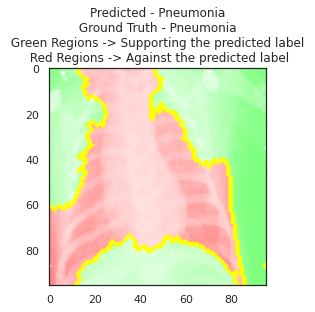

  7%|▋         | 1/15 [00:09<02:08,  9.14s/it]

  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 [==============================] - 0s 35ms/step
Intercept 0.833929190234404
Prediction_local [0.98000429]
Right: 0.99998045


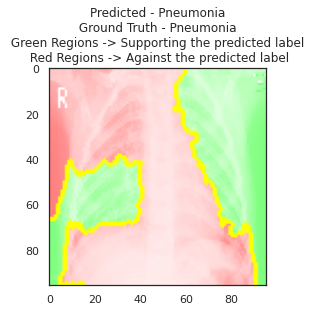

 13%|█▎        | 2/15 [00:17<01:51,  8.60s/it]

  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 [==============================] - 0s 29ms/step
Intercept 0.7764723315210198
Prediction_local [0.08135293]
Right: 0.100254


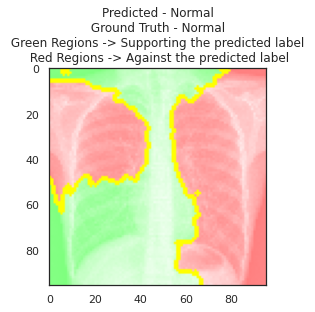

 20%|██        | 3/15 [00:26<01:46,  8.87s/it]

  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 [==============================] - 0s 23ms/step
Intercept 0.7758923944817367
Prediction_local [0.58773874]
Right: 0.67849225


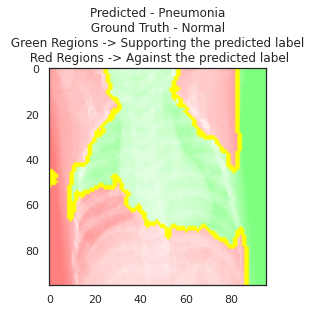

 27%|██▋       | 4/15 [00:36<01:40,  9.11s/it]

  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 [==============================] - 0s 24ms/step
Intercept 0.9016324763667923
Prediction_local [0.35680558]
Right: 0.33835334


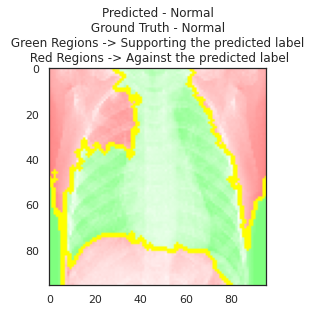

 33%|███▎      | 5/15 [00:44<01:28,  8.83s/it]

  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 [==============================] - 0s 28ms/step
Intercept 0.7707933749578917
Prediction_local [1.00395497]
Right: 0.99915135


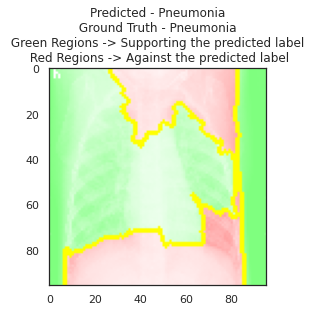

 40%|████      | 6/15 [00:54<01:22,  9.13s/it]

  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 [==============================] - 0s 36ms/step
Intercept 0.9643420064000943
Prediction_local [1.00032806]
Right: 0.99999964


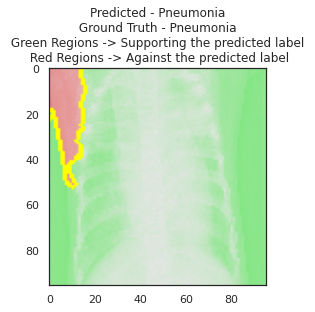

 47%|████▋     | 7/15 [01:04<01:15,  9.46s/it]

  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 [==============================] - 0s 27ms/step
Intercept 1.0587991437682065
Prediction_local [0.29967467]
Right: 0.24803546


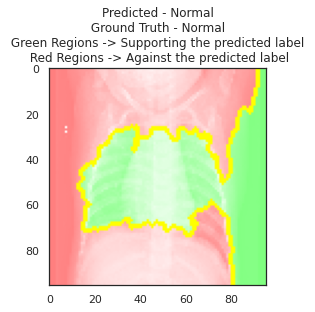

 53%|█████▎    | 8/15 [01:13<01:06,  9.44s/it]

  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 [==============================] - 0s 26ms/step
Intercept 0.9462326318038653
Prediction_local [1.02100245]
Right: 1.0


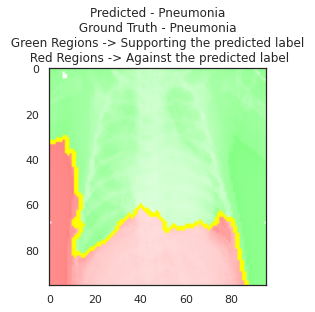

 60%|██████    | 9/15 [01:23<00:58,  9.73s/it]

  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 [==============================] - 0s 32ms/step
Intercept 0.9632331176668919
Prediction_local [1.00644737]
Right: 0.9999969


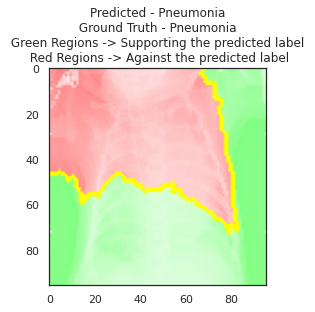

 67%|██████▋   | 10/15 [01:33<00:48,  9.79s/it]

  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 [==============================] - 0s 24ms/step
Intercept 0.9989952773740982
Prediction_local [1.00019119]
Right: 1.0


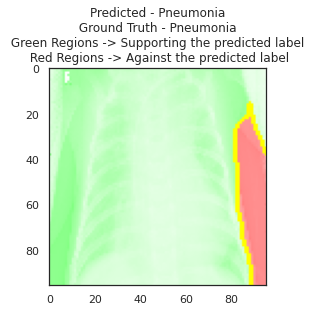

 73%|███████▎  | 11/15 [01:43<00:38,  9.65s/it]

  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 [==============================] - 0s 28ms/step
Intercept 1.0779611257794435
Prediction_local [0.03438459]
Right: 0.04559055


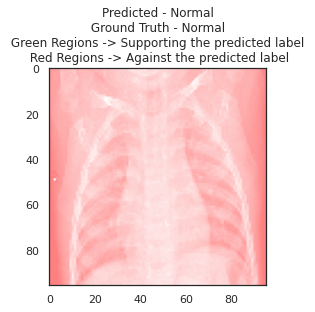

 80%|████████  | 12/15 [01:54<00:29,  9.99s/it]

  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 [==============================] - 0s 79ms/step
Intercept 0.9422408220118812
Prediction_local [0.99722744]
Right: 0.99999964


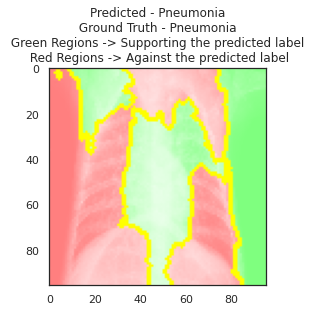

 87%|████████▋ | 13/15 [02:03<00:19,  9.96s/it]

  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 [==============================] - 0s 22ms/step
Intercept 0.8815200687566926
Prediction_local [1.00065618]
Right: 0.9999839


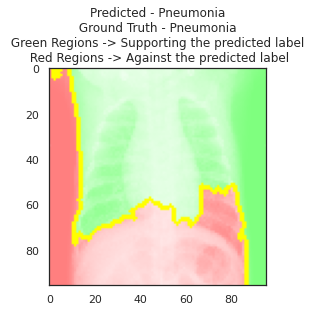

 93%|█████████▎| 14/15 [02:14<00:10, 10.06s/it]

  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 [==============================] - 0s 40ms/step
Intercept 0.9906319294330951
Prediction_local [1.00084941]
Right: 0.9999987


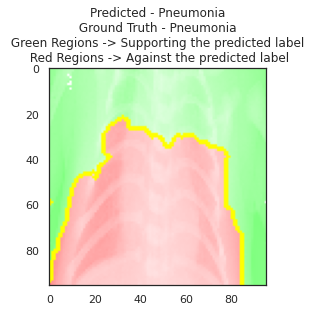

100%|██████████| 15/15 [02:26<00:00,  9.75s/it]


In [ ]:
import random

n = 15
idx = []

for _ in tqdm(range(n)):
    index = random.randint(0,len(list(X_test))-1)
    idx.append(index)
    explain_image(X_test[index], index)

  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 [==============================] - 0s 31ms/step
Intercept 0.7983431072078013
Prediction_local [0.03074616]
Right: 0.09488353


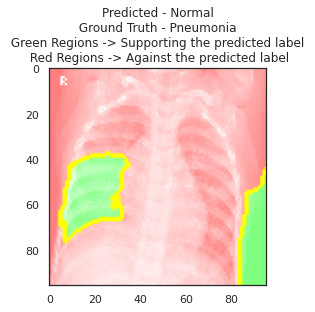

  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 [==============================] - 0s 24ms/step
Intercept 0.8174868945549099
Prediction_local [0.23408973]
Right: 0.29731673


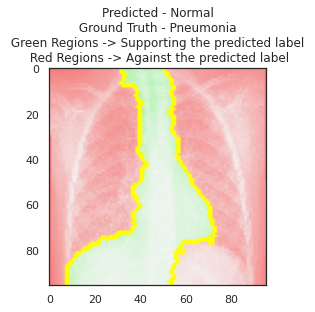

  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 [==============================] - 0s 25ms/step
Intercept 0.8517699636592478
Prediction_local [0.15823231]
Right: 0.3111399


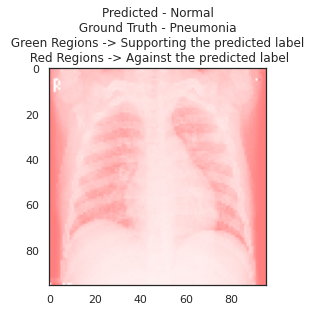

In [ ]:
# explain_image(X_test[391], 391)
# explain_image(X_test[473], 473)
# explain_image(X_test[496], 496)

## Class Activation Maps

Here, we use Gradient-weighted Class Activation Maps. It uses the gradients of any target concept, **flowing into the final convolutional layer** to produce a localization map highlighting the important regions in the image for predicting the concept.


So, to explain in simple terms, we **take the final convolutional feature map** and then **weigh every channel in that feature with the gradient of the class with respect to the channel**.

How intensely the input image activates different channels by how important each channel is with regard to the class. The best part is it does not require any re-training or change in the existing architecture unlike CAM, where a Global Average Pooling layer is needed to generate activations.

In [ ]:
def make_gradcam_heatmap(img_array, model, last_conv_layer_name, classifier_layer_names):
    # First, we create a model that maps the input image to the activations
    # of the last conv layer
    last_conv_layer = model.get_layer(last_conv_layer_name)
    last_conv_layer_model = tf.keras.Model(model.inputs, last_conv_layer.output)

    # Second, we create a model that maps the activations of the last conv
    # layer to the final class predictions
    classifier_input = tf.keras.Input(shape = last_conv_layer.output.shape[1:])
    x = classifier_input
    for layer_name in classifier_layer_names:
        x = model.get_layer(layer_name)(x)
    classifier_model = tf.keras.Model(classifier_input, x)

    # Then, we compute the gradient of the top predicted class for our input image
    # with respect to the activations of the last conv layer
    with tf.GradientTape() as tape:
        # Compute activations of the last conv layer and make the tape watch it
        last_conv_layer_output = last_conv_layer_model(img_array)
        tape.watch(last_conv_layer_output)
        # Compute class predictions
        preds = classifier_model(last_conv_layer_output)
        top_pred_index = tf.argmax(preds[0])
        top_class_channel = preds[:, top_pred_index]

    # This is the gradient of the top predicted class with regard to
    # the output feature map of the last conv layer
    grads = tape.gradient(top_class_channel, last_conv_layer_output)

    # This is a vector where each entry is the mean intensity of the gradient
    # over a specific feature map channel
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    # We multiply each channel in the feature map array
    # by "how important this channel is" with regard to the top predicted class
    last_conv_layer_output = last_conv_layer_output.numpy()[0]
    pooled_grads = pooled_grads.numpy()
    for i in range(pooled_grads.shape[-1]):
        last_conv_layer_output[:, :, i] *= pooled_grads[i]

    # The channel-wise mean of the resulting feature map
    # is our heatmap of class activation
    heatmap = np.mean(last_conv_layer_output, axis=-1)

    # For visualization purpose, we will also normalize the heatmap between 0 & 1
    heatmap = np.maximum(heatmap, 0) / np.max(heatmap)
    return heatmap

In [ ]:
# Print the name of each layer of the model
lay = []
for layer in model.layers:
    lay.append(layer.name)

In [ ]:
last_conv_layer_name = lay[9]
classifier_layer_names = lay[10:]

In [ ]:
import matplotlib.cm as cm

def superimpose_gradcam(img, heatmap, save_path="grad_cam_image.jpg", alpha=0.4):
    '''
    Superimpose Grad-CAM Heatmap on image
    '''
    # We rescale image to a range 0-255 and resize to 128x128
    img = np.uint8(255 * img)
    # We rescale heatmap to a range 0-255
    heatmap = np.uint8(255 * heatmap)

    # We use jet colormap to colorize heatmap
    jet = cm.get_cmap("jet")

    # We use RGB values of the colormap
    jet_colors = jet(np.arange(256))[:, :3]
    jet_heatmap = jet_colors[heatmap]

    # We create an image with RGB colorized heatmap
    jet_heatmap = tf.keras.preprocessing.image.array_to_img(jet_heatmap)
    jet_heatmap = jet_heatmap.resize((img.shape[1], img.shape[0]))
    jet_heatmap = tf.keras.preprocessing.image.img_to_array(jet_heatmap)

    # Superimpose the heatmap on original image
    superimposed_img = jet_heatmap * 0.4 + img
    superimposed_img = tf.keras.preprocessing.image.array_to_img(superimposed_img)

    # Save and display the superimposed image
    superimposed_img.save(save_path)

    # Display Grad CAM
    display(Image(save_path))

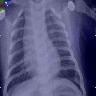

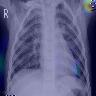

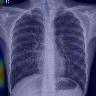

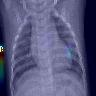

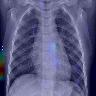

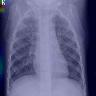

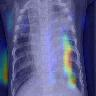

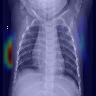

<ipython-input-89-e498a2525818>:46: RuntimeWarning: invalid value encountered in true_divide
  heatmap = np.maximum(heatmap, 0) / np.max(heatmap)


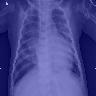

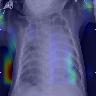

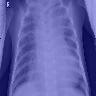

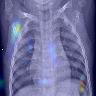

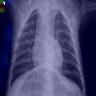

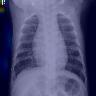

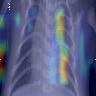

In [ ]:
model_path = "/content/drive/MyDrive/XAI/esame/notebook/grad_cam"

for index in idx:
  # Generate class activation heatmap
  heatmap = make_gradcam_heatmap(
      np.expand_dims(X_test[index], axis=0), 
      model, 
      last_conv_layer_name, 
      classifier_layer_names
  )
  # superimpose_gradcam(X_test[index], heatmap, save_path=os.path.join(model_path, str(index)+'.jpg')) 
  superimpose_gradcam(X_test[index], heatmap)

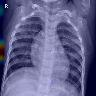

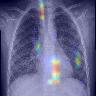

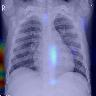

In [ ]:
# idx_1 = [391, 473, 496]

# for index in idx_1:
#   # Generate class activation heatmap
#   heatmap = make_gradcam_heatmap(
#       np.expand_dims(X_test[index], axis=0), 
#       model, 
#       last_conv_layer_name, 
#       classifier_layer_names
#   )
#   # superimpose_gradcam(X_test[index], heatmap, save_path=os.path.join(model_path, str(index)+'.jpg')) 
#   superimpose_gradcam(X_test[index], heatmap)

# References


- DATASET: https://www.kaggle.com/datasets/paultimothymooney/chest-xray-pneumonia

- MODEL:
  - **VGG16**: https://keras.io/api/applications/vgg/

- EXPLAINABILITY:
  - **SHAP**: https://shap.readthedocs.io/en/stable/example_notebooks/image_examples/image_classification/PyTorch%20Deep%20Explainer%20MNIST%20example.html
  - **LIME**: https://lime-ml.readthedocs.io/en/latest/
  - **GRADCAM**: https://keras.io/examples/vision/grad_cam/
  
